In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, GRU, BatchNormalization
from keras import optimizers

Using TensorFlow backend.


In [3]:
!pip freeze

absl-py==0.5.0
alabaster==0.7.12
anaconda-client==1.6.14
anaconda-navigator==1.8.1
anaconda-project==0.8.2
asn1crypto==0.24.0
astor==0.7.1
astroid==2.0.4
astropy==3.0.5
atomicwrites==1.2.1
attrs==18.2.0
autopep8==1.4.3
Babel==2.6.0
backcall==0.1.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.3
bitarray==0.8.3
bkcharts==0.2
blaze==0.11.3
bleach==3.0.2
bokeh==0.13.0
boto==2.48.0
Bottleneck==1.2.1
category-encoders==2.0.0
certifi==2019.3.9
cffi==1.11.5
chardet==3.0.4
Click==7.0
cloudpickle==0.6.1
clyent==1.2.2
colorama==0.4.0
comtypes==1.1.7
conda==4.6.13
contextlib2==0.5.5
convertdate==2.1.3
cryptography==2.6.1
cycler==0.10.0
Cython==0.29
cytoolz==0.9.0.1
dask==0.19.4
datashape==0.5.4
DAWG-Python==0.7.2
decorator==4.3.0
defusedxml==0.5.0
distributed==1.23.3
docopt==0.6.2
docutils==0.14
entrypoints==0.2.3
ephem==3.7.6.0
et-xmlfile==1.0.1
fastcache==1.0.2
fbprophet==0.4.post2
filelock==3.0.4
Flask==1.0.2
Flask-Cors==3.0.6
future==0.16.0
gast==0.2.0
gevent==1.3.0
glob2==0.6

In [4]:
np.random.seed(1234)  
model_path = './Output/regression_model.h5'

### Загрузка данных

In [5]:
train_df = pd.read_csv('./data/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [6]:
train_df = train_df.sort_values(['id','cycle'])

In [7]:
test_df = pd.read_csv('./data/PM_test.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [8]:
truth_df = pd.read_csv('./data/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

### Подготовка таргета

In [9]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

### Нормализация

In [10]:
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

c:\users\евгений\lstmkeras\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [12]:
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

In [13]:
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

In [14]:
train_df.to_csv('./data/PredictiveManteinanceEngineTraining.csv', encoding='utf-8',index = None)
test_df.to_csv('./data/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)

In [15]:
train_df = pd.read_csv('./data/PredictiveManteinanceEngineTraining.csv', encoding='utf-8')
test_df = pd.read_csv('./data/PredictiveManteinanceEngineValidation.csv', encoding='utf-8')

### Генерация последовательностей для входа реккурентной сети

In [16]:
sequence_length = 50

In [17]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [18]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

In [19]:
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

In [20]:
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [21]:
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(15631, 50, 25)


In [22]:
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

### Обучение

In [23]:
def sMAPE(y_true, y_pred):
    return 100 * K.mean(K.abs(y_pred - y_true) / (K.abs(y_pred) + K.abs(y_true)), axis=-1)

In [24]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [25]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [26]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(BatchNormalization(input_shape=(sequence_length, nb_features), momentum=0.67))
model.add(GRU(
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization(momentum=0.67))
model.add(GRU(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss=root_mean_squared_error, optimizer=adam, metrics=['mae', sMAPE])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 50, 25)            100       
_________________________________________________________________
gru_1 (GRU)                  (None, 50, 100)           37800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 50, 100)           400       
_________________________________________________________________
gru_2 (GRU)                  (None, 50)                22650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
__________

In [27]:
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

print(history.history.keys())

Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 19s - loss: 96.5362 - mean_absolute_error: 79.8177 - sMAPE: 84.9118 - val_loss: 85.8290 - val_mean_absolute_error: 73.5751 - val_sMAPE: 69.8555
Epoch 2/100
 - 8s - loss: 90.4763 - mean_absolute_error: 72.3008 - sMAPE: 66.8773 - val_loss: 82.0202 - val_mean_absolute_error: 69.4713 - val_sMAPE: 61.5161
Epoch 3/100
 - 8s - loss: 87.3889 - mean_absolute_error: 69.2215 - sMAPE: 62.1744 - val_loss: 78.9019 - val_mean_absolute_error: 66.6829 - val_sMAPE: 57.5748
Epoch 4/100
 - 8s - loss: 84.5233 - mean_absolute_error: 66.5799 - sMAPE: 58.5467 - val_loss: 75.9569 - val_mean_absolute_error: 64.0241 - val_sMAPE: 53.9066
Epoch 5/100
 - 8s - loss: 81.9976 - mean_absolute_error: 64.3042 - sMAPE: 55.7436 - val_loss: 73.1523 - val_mean_absolute_error: 61.4524 - val_sMAPE: 50.4136
Epoch 6/100
 - 8s - loss: 79.5001 - mean_absolute_error: 61.9998 - sMAPE: 52.9128 - val_loss: 70.6377 - val_mean_absolute_error: 59.4993 - val_sMAPE: 48.6892
Epo

Epoch 53/100
 - 8s - loss: 20.0567 - mean_absolute_error: 11.9712 - sMAPE: 11.0450 - val_loss: 25.7403 - val_mean_absolute_error: 18.6084 - val_sMAPE: 12.4416
Epoch 54/100
 - 8s - loss: 19.4729 - mean_absolute_error: 11.6191 - sMAPE: 10.9066 - val_loss: 25.0314 - val_mean_absolute_error: 17.9032 - val_sMAPE: 11.5410
Epoch 55/100
 - 8s - loss: 19.2014 - mean_absolute_error: 11.5216 - sMAPE: 10.8098 - val_loss: 26.6192 - val_mean_absolute_error: 18.8678 - val_sMAPE: 12.6843
Epoch 56/100
 - 8s - loss: 18.6249 - mean_absolute_error: 11.2241 - sMAPE: 10.7051 - val_loss: 26.1854 - val_mean_absolute_error: 18.7112 - val_sMAPE: 12.7433
Epoch 57/100
 - 9s - loss: 18.2204 - mean_absolute_error: 10.9636 - sMAPE: 10.4381 - val_loss: 27.2170 - val_mean_absolute_error: 19.0360 - val_sMAPE: 12.6462
Epoch 58/100
 - 9s - loss: 17.8602 - mean_absolute_error: 10.8239 - sMAPE: 10.3710 - val_loss: 25.3597 - val_mean_absolute_error: 17.9589 - val_sMAPE: 12.3589
Epoch 59/100
 - 9s - loss: 17.4764 - mean_abso

### Кривые обучения

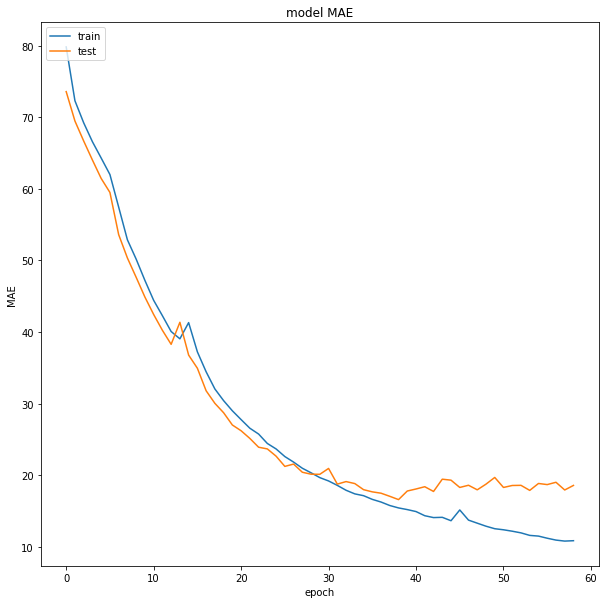

In [28]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_mae.png")

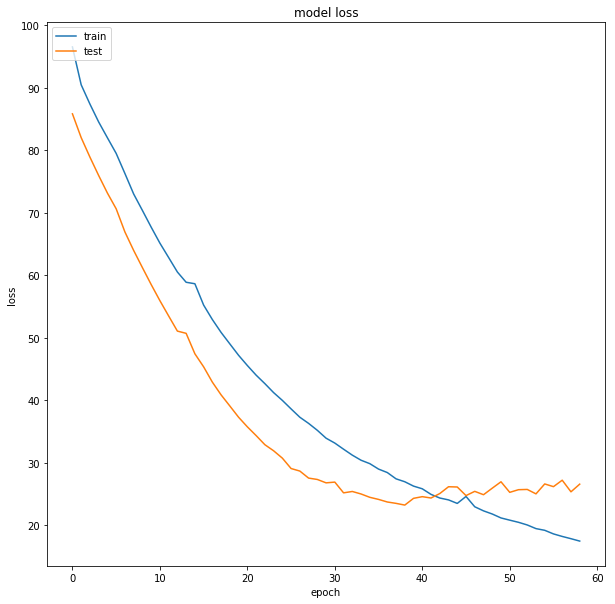

In [29]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_regression_loss.png")

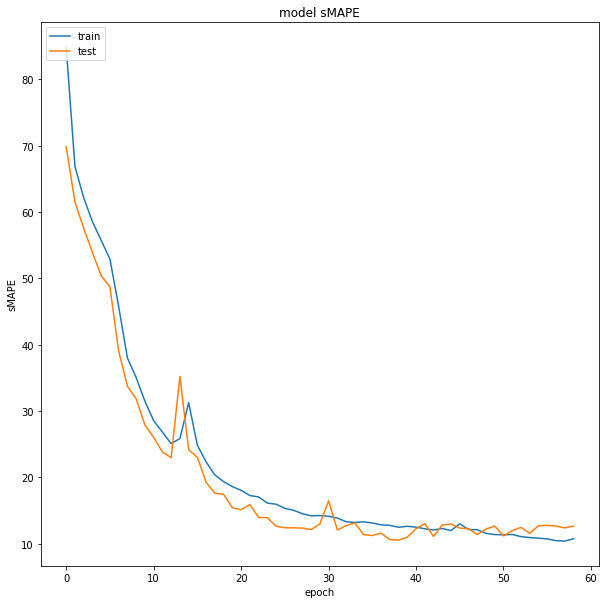

In [30]:
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['sMAPE'])
plt.plot(history.history['val_sMAPE'])
plt.title('model sMAPE')
plt.ylabel('sMAPE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("./Output/model_regression_sMAPE.png")

### Валидация

In [48]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))

15631/15631 [==============================] - 3s 221us/step

MAE: 7.748673147145773


In [32]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

15631/15631 [==============================] - 4s 227us/step


In [33]:
test_set = pd.DataFrame(y_pred)
test_set.to_csv('./Output/submit_train.csv', index = None)

In [34]:
test_set = pd.read_csv('./Output/submit_train.csv')

In [35]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

In [36]:
seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)

seq_array_test_last
(93, 50, 25)


In [37]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print("label_array_test_last")
print(label_array_test_last.shape)

label_array_test_last
(93, 1)



MAE: 10.373575959154355


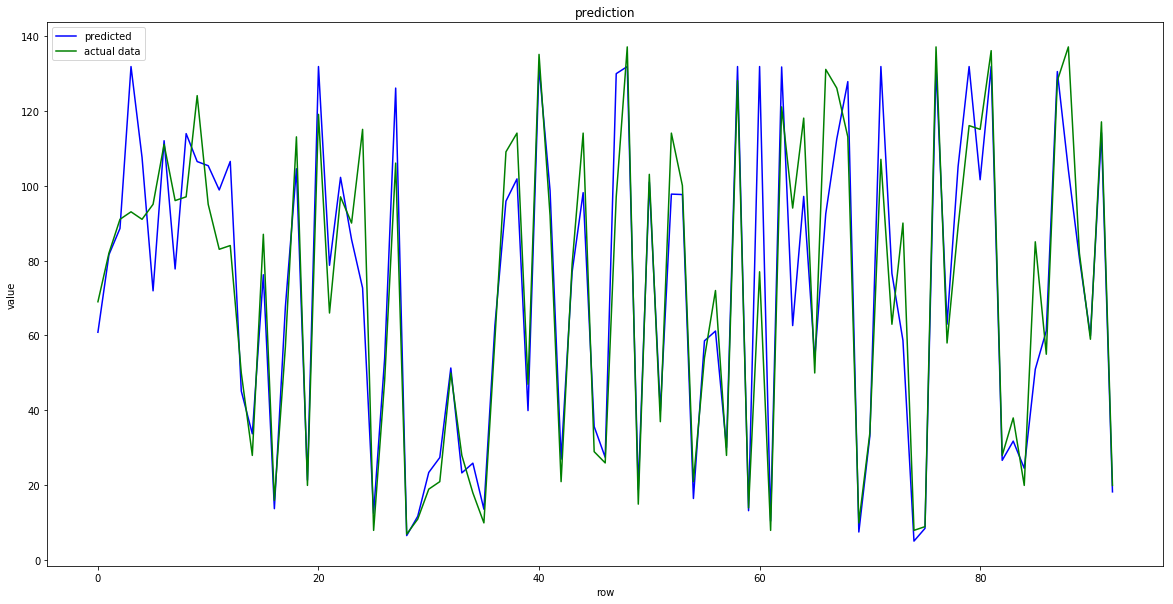

In [38]:
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'root_mean_squared_error': root_mean_squared_error,
                                                     'sMAPE': sMAPE})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('./Output/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(20, 10))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("./Output/model_regression_verify.png")

In [39]:
keras.utils.plot_model(estimator, to_file='./Output/model.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [40]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true+1))) * 100

In [41]:
mean_absolute_percentage_error(y_true_test, y_pred_test)

15.314213931560516

In [42]:
mean_squared_error(y_true_test, y_pred_test)

226.01779

### Кастомная метрика соревнования

In [43]:
def score(y_true, y_pred):
    score = 0
    for true, pred in zip(y_true, y_pred):
        if true > pred:
            score += math.e**((true-pred)/13) - 1
        else:
            score += math.e**((pred-true)/10) - 1
    return score

In [44]:
y_pred_test = estimator.predict(seq_array_test_last)
y_true_test = label_array_test_last

In [45]:
score(y_true_test, y_pred_test)

array([514.6889], dtype=float32)

Так как метрика штрафует меньше за недопредсказания, можно откалибровать выход модели и получить лучший скор.

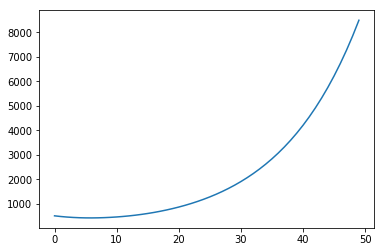

In [46]:
l = []
for i in range(0, 50):
    l.append(score(y_true_test, y_pred_test-i))
plt.plot(l)

In [47]:
l

[array([514.6889], dtype=float32),
 array([486.9946], dtype=float32),
 array([465.12228], dtype=float32),
 array([448.57404], dtype=float32),
 array([437.08347], dtype=float32),
 array([430.8636], dtype=float32),
 array([429.52643], dtype=float32),
 array([433.03113], dtype=float32),
 array([440.83057], dtype=float32),
 array([452.6775], dtype=float32),
 array([468.40625], dtype=float32),
 array([488.28723], dtype=float32),
 array([512.4236], dtype=float32),
 array([540.7055], dtype=float32),
 array([573.5044], dtype=float32),
 array([610.76807], dtype=float32),
 array([652.73785], dtype=float32),
 array([699.9728], dtype=float32),
 array([752.4186], dtype=float32),
 array([810.10077], dtype=float32),
 array([873.33813], dtype=float32),
 array([942.6593], dtype=float32),
 array([1018.28174], dtype=float32),
 array([1100.7334], dtype=float32),
 array([1190.4635], dtype=float32),
 array([1287.955], dtype=float32),
 array([1393.8634], dtype=float32),
 array([1508.6692], dtype=float32),
 a

In [49]:
min(l)

array([429.52643], dtype=float32)